In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)


In [6]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print("Using %d samples for training and %d for validation" % (len(train_dataframe), len(val_dataframe)))

Using 242 samples for training and 61 for validation


In [7]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [8]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = layers.Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature

In [9]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup

    lookup = lookup_class(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup.adapt(feature_ds)

    encoded_feature = lookup(feature)
    return encoded_feature

In [15]:
def encode_features():
    sex = keras.Input(shape=(1,), name="sex", dtype="int64")
    cp = keras.Input(shape=(1,), name="cp", dtype="int64")
    fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
    restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
    exang = keras.Input(shape=(1,), name="exang", dtype="int64")
    ca = keras.Input(shape=(1,), name="ca", dtype="int64")

    thal = keras.Input(shape=(1,), name="thal", dtype="string")

    # Numerical features
    age = keras.Input(shape=(1,), name="age")
    trestbps = keras.Input(shape=(1,), name="trestbps")
    chol = keras.Input(shape=(1,), name="chol")
    thalach = keras.Input(shape=(1,), name="thalach")
    oldpeak = keras.Input(shape=(1,), name="oldpeak")
    slope = keras.Input(shape=(1,), name="slope")

    all_inputs = [
        sex,
        cp,
        fbs,
        restecg,
        exang,
        ca,
        thal,
        age,
        trestbps,
        chol,
        thalach,
        oldpeak,
        slope,
    ]

    # Integer categorical features
    sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
    cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
    fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
    restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
    exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
    ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

    # String categorical features
    thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

    # Numerical features
    age_encoded = encode_numerical_feature(age, "age", train_ds)
    trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
    chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
    thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
    oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
    slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

    all_features = layers.concatenate(
        [
            sex_encoded,
            cp_encoded,
            fbs_encoded,
            restecg_encoded,
            exang_encoded,
            slope_encoded,
            ca_encoded,
            thal_encoded,
            age_encoded,
            trestbps_encoded,
            chol_encoded,
            thalach_encoded,
            oldpeak_encoded,
        ]
    )
    
    def attention_mechanism(inputs):
        # Reshape inputs to [batch_size, num_features, 1] for dot-product attention
        inputs_with_dim = tf.expand_dims(inputs, axis=-1)

        # Calculate the importance of each input feature using dot-product attention
        attention_weights = tf.nn.softmax(tf.matmul(inputs_with_dim, inputs_with_dim, transpose_a=True), axis=1)

        # Weighted sum of features using attention weights
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        return context_vector

    # Add Attention mechanism
    attention_output = layers.Attention(name="attention")([all_features, all_features])

    x = layers.Dense(32, activation="relu")(attention_output)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(all_inputs, output)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

    return model


   

In [16]:
train_ds = dataframe_to_dataset(train_dataframe).batch(32)
val_ds = dataframe_to_dataset(val_dataframe).batch(32)


In [17]:
model = encode_features()

In [18]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 1s 62ms/step - loss: 0.7546 - accuracy: 0.5537 - val_loss: 0.6568 - val_accuracy: 0.6557
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6739 - accuracy: 0.6281 - val_loss: 0.5963 - val_accuracy: 0.7541
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6006 - accuracy: 0.6777 - val_loss: 0.5387 - val_accuracy: 0.8033
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5799 - accuracy: 0.7355 - val_loss: 0.5210 - val_accuracy: 0.7541
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5744 - accuracy: 0.6942 - val_loss: 0.4751 - val_accuracy: 0.7869
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5266 - accuracy: 0.7190 - val_loss: 0.4580 - val_accuracy: 0.7705
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4871 - accuracy: 0.7810 - val_loss: 0.4405 - val_accuracy: 0.8033
Epoch 8/50
8/8 [=================

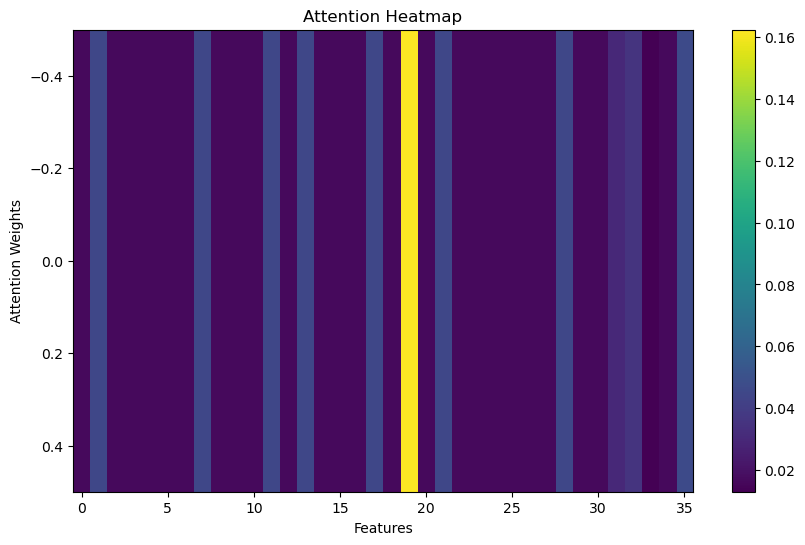

In [36]:
import matplotlib.pyplot as plt

# Function to get the attention weights for a specific input sample
def get_attention_weights(model, input_dict):
    attention_layer_output = model.get_layer("attention")
    attention_model = keras.Model(inputs=model.input, outputs=attention_layer_output.output)
    attention_output = attention_model(input_dict)
    return attention_output

# Sample input
sample_input = {
    "age": tf.convert_to_tensor([60]),
    "sex": tf.convert_to_tensor([1]),
    "cp": tf.convert_to_tensor([1]),
    "trestbps": tf.convert_to_tensor([145]),
    "chol": tf.convert_to_tensor([233]),
    "fbs": tf.convert_to_tensor([1]),
    "restecg": tf.convert_to_tensor([2]),
    "thalach": tf.convert_to_tensor([150]),
    "exang": tf.convert_to_tensor([0]),
    "oldpeak": tf.convert_to_tensor([2.3]),
    "slope": tf.convert_to_tensor([3]),
    "ca": tf.convert_to_tensor([0]),
    "thal": tf.convert_to_tensor(["fixed"]),
}

# Get attention weights for the sample input
attention_output = get_attention_weights(model, sample_input)

# Normalize attention weights to be between 0 and 1
normalized_attention = tf.nn.softmax(attention_output, axis=-1)

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'normalized_attention' and 'sample_input' are properly defined.

feature_names = list(sample_input.keys())
num_features = len(feature_names)
tick_placement = np.arange(0, num_features, 1)

plt.figure(figsize=(10, 6))
plt.imshow(normalized_attention.numpy(), cmap="viridis", aspect="auto")

plt.xlabel("Features")
plt.ylabel("Attention Weights")
plt.title("Attention Heatmap")
plt.colorbar()
plt.show()


